In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [18]:
f0, f1 = '217', '217'
split0, split1 = '1', '2'
lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

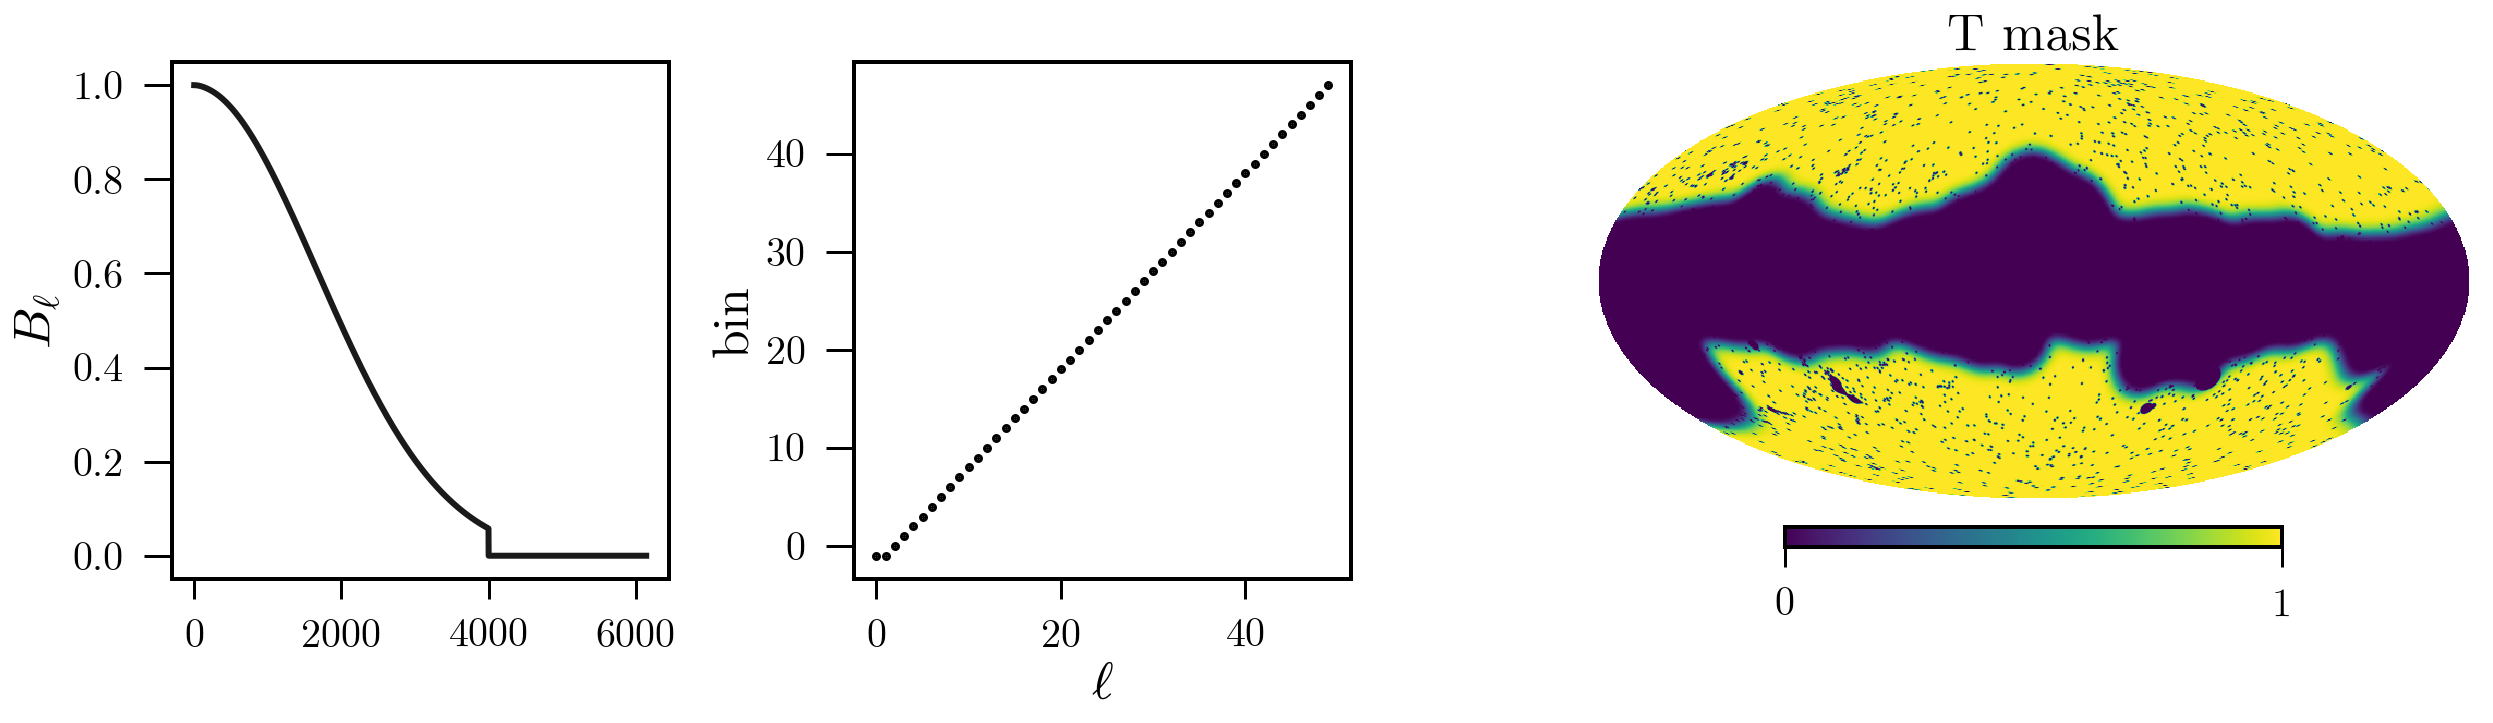

In [29]:
beam_filename = f'planck_beam/beam_probably_used_in_2015_likelihood_{f0}hm1x{f1}hm2.dat.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

binleft, binright = np.arange(2,lmax+1), np.arange(2,lmax+1)
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 / np.sum(bpws == bpws[l]) for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)

fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws[:50], 'k.')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

We look in the `II_COV` (4th column of the frequency maps) for the variance on the I stokes map. The unobserved/missing pixels are marked as the healpix missing value, which is something like -1.6e30. We then set these to zero in the maps and mask, for each split (there are big differences between splits!).

In [30]:
c0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
c1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'
cov0 = hp.read_map(c0_file, field=4, verbose=False) # II_COV
cov1 = hp.read_map(c1_file, field=4, verbose=False) # II_COV

badpix0 = (cov0<-1e30)
badpix1 = (cov1<-1e30)

m0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
m1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'
map0 = hp.read_map(m0_file, field=0, verbose=False) # I
map1 = hp.read_map(m1_file, field=0, verbose=False) # I

map0[badpix0] = 0.0
map1[badpix1] = 0.0
mask0t[badpix0] = 0.0
mask1t[badpix1] = 0.0

In [49]:
def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    print(mono, dipole)
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
        m.flat[ipix] -= dipole[0] * x
        m.flat[ipix] -= dipole[1] * y
        m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
        
    return m

map0_subtracted = subtract_mono_di(map0, mask0t)
map1_subtracted = subtract_mono_di(map1, mask1t)

0.0001131643532823303 [ 2.73288866e-06 -6.61065066e-07  2.82938138e-06]
0.00011308768733955689 [ 1.53095048e-06 -1.56058624e-06  3.69505609e-06]


We need to correct for the pixel window, thee beam, and the mode coupling!

In [50]:
pixel_window = np.load('pixwin2048.npy')

In [51]:
i0 = nmt.NmtField(mask0t,[map0_subtracted], beam=(Bl*pixel_window), n_iter=3)
i1 = nmt.NmtField(mask1t,[map1_subtracted], beam=(Bl*pixel_window), n_iter=3)


cl_coupled=nmt.compute_coupled_cell(i0,i1)
w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(i0,i1,b)
cl_00=w0.decouple_cell(cl_coupled)[0]

In [52]:
lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'TT_{f0}x{f1}' + '.dat',unpack=True)
ref_fac = l_ref*(l_ref+1)/(2*np.pi)
dl_ref = cl_ref * ref_fac

In [53]:
cl_from_zero = np.zeros(lmax+1)
cl_from_zero[lb.astype('int')] = cl_00 * 1e12

binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))

ell_sub_list = [ np.arange(l,r) for (l,r) in zip(binleft, binright+1) ]
l_b_rb = np.array([np.sum(ell_sub) / len(ell_sub) for ell_sub in ell_sub_list])
weights = np.arange(lmax+1) * (np.arange(lmax+1) + 1) # ell * (ell+1) weighted C_ell
cl_b = np.array([np.sum((weights * cl_from_zero)[ell_sub]
              ) / np.sum(weights[ell_sub]) for ell_sub in ell_sub_list])

## Check against reference spectra

In [54]:
ref_filt = np.in1d(binleft, lmin_)

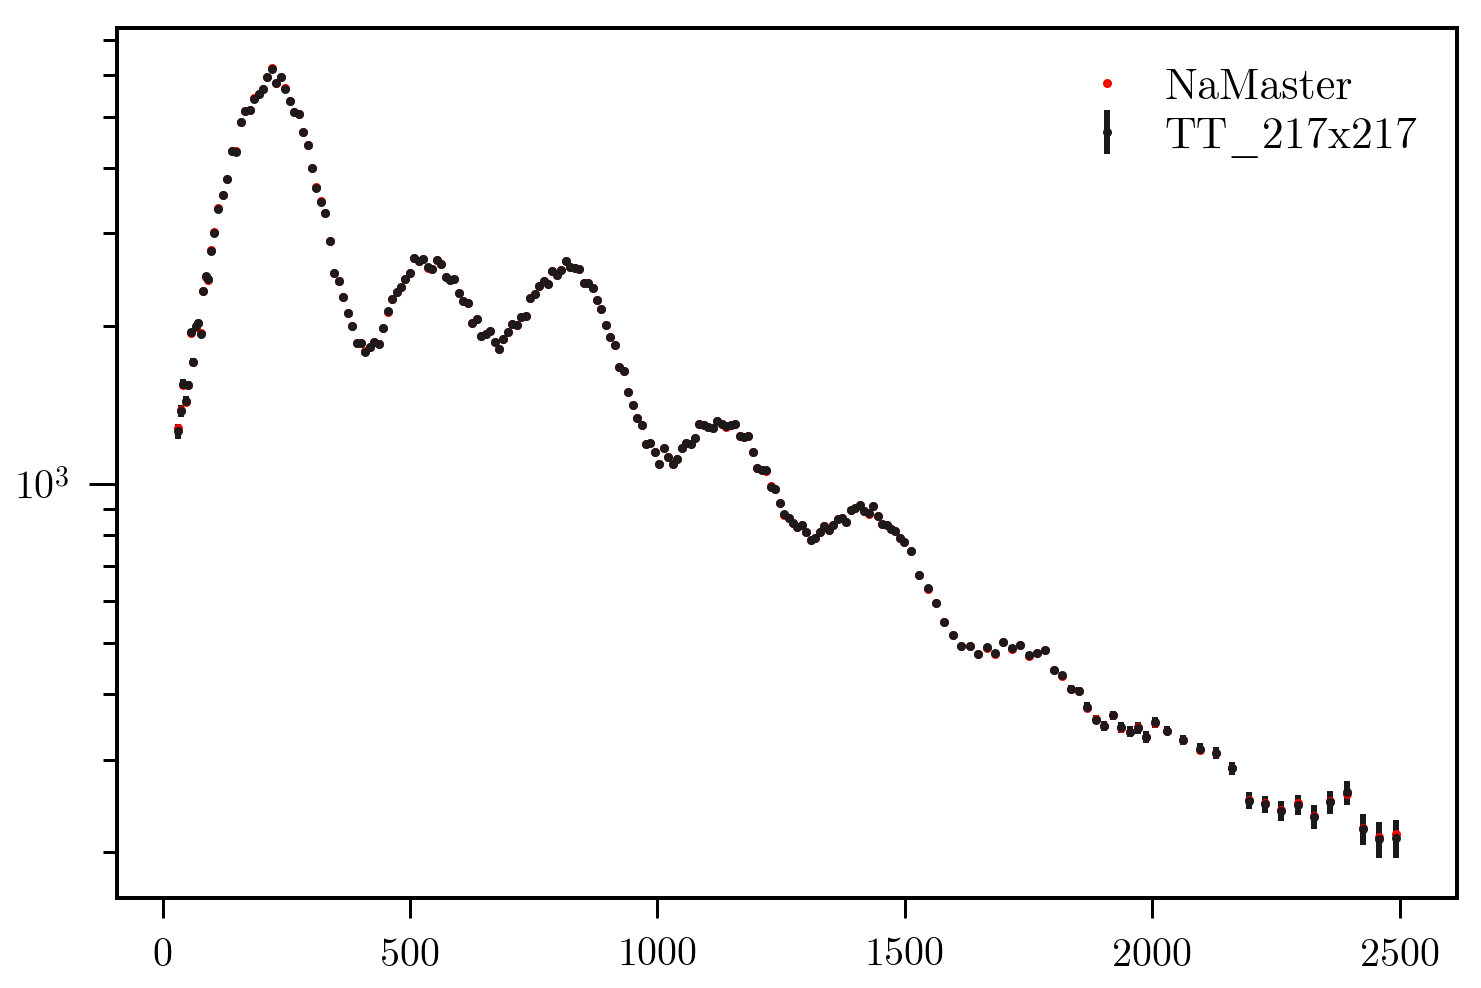

In [55]:
plt.figure(figsize=(12,8))
plt.errorbar(l_ref,dl_ref,error_ref*ref_fac,fmt='.',label='%s'%f'TT_{f0}x{f1}')
plt.plot(l_b_rb[ref_filt], cl_b[ref_filt] * ref_fac,'r.',label=r"NaMaster")

plt.legend()
plt.yscale('log')

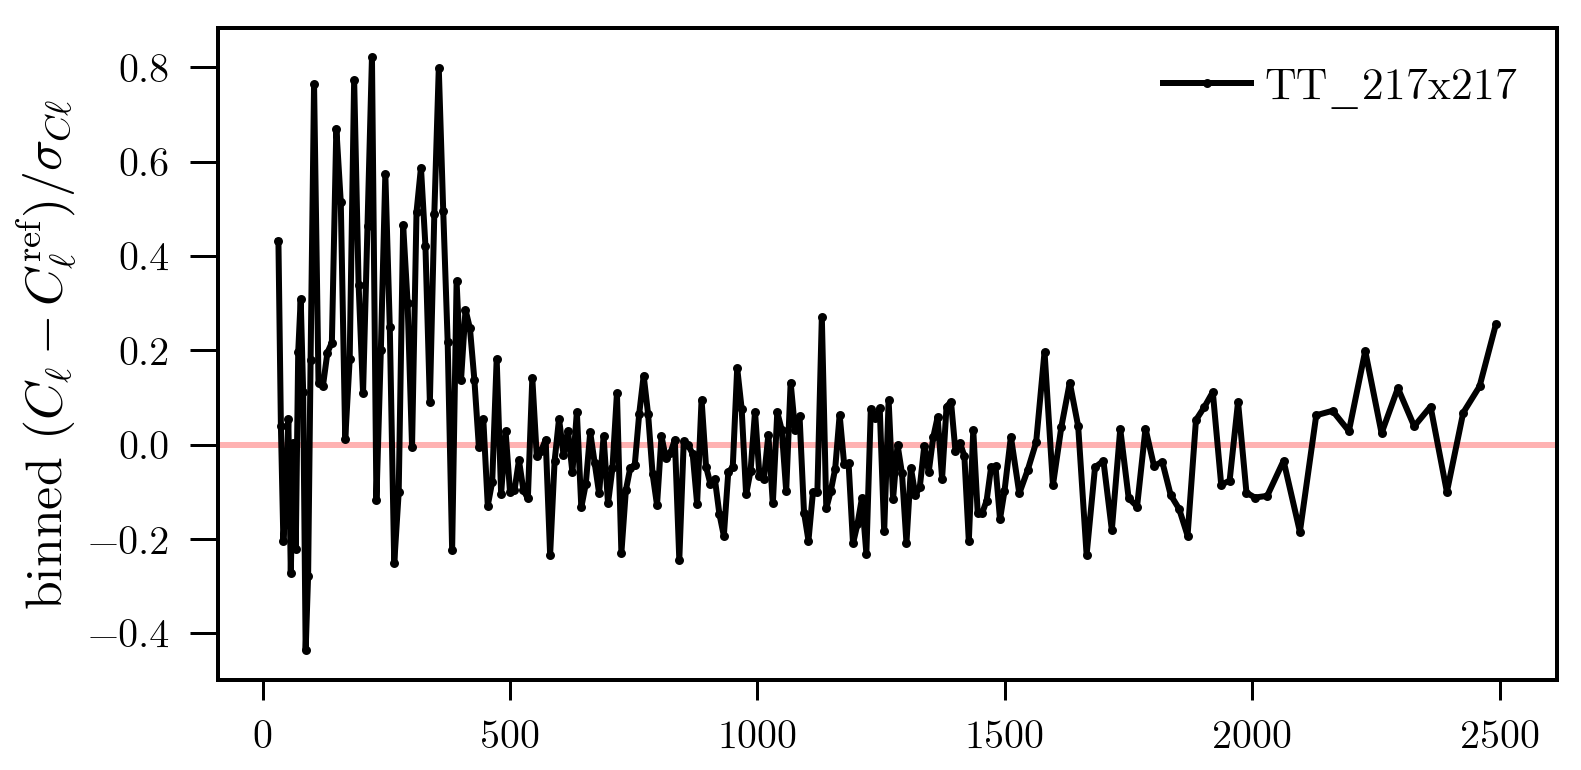

In [56]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.plot( l_ref,(cl_b[ref_filt] - cl_ref) / (error_ref),
         'k.-', label=f'TT_{f0}x{f1}')
plt.ylabel(r'binned $(C_{\ell} - C_{\ell}^{\mathrm{ref}}) / \sigma_{C\ell}$')
plt.legend()
# plt.ylim(-1,1);

## some Planck covariance code

In [46]:
# class PlanckCov:
#     def __init__(self, covpath='cov/covmat.dat', vecpath='cov/plikdata.dat'):
#         self.cov = np.genfromtxt(covpath)
#         self.plikdata = np.genfromtxt(vecpath)
                 
#     def get_subcov(self, spec, debug=True):
#         """
#         spec: TT, TE, or EE
#         cross: string, i.e. '100x100', '143x143', '143x217', '217x217'
        
#         returns tuple: 
#             ells, cl, subcovariance matrix 
#         """
#         subarray_indices = np.arange(
#             self.plikdata.shape[0]-1)[(np.diff(self.plikdata[:,0]) < 0)] + 1
#         keys = ['TT_100x100', 'TT_143x143', 'TT_143x217', 'TT_217x217',
#                 'EE_100x100', 'EE_100x143', 'EE_100x217', 'EE_143x143', 'EE_143x217', 'EE_217x217',
#                 'TE_100x100', 'TE_100x143', 'TE_100x217', 'TE_143x143', 'TE_143x217', 'TE_217x217']
#         key_i = list(range(len(keys)))
#         key_index_dict = dict(zip(keys,key_i))
#         i = key_index_dict[spec]
        
#         subcov = self.cov[subarray_indices[i]:subarray_indices[i+1], 
#                               subarray_indices[i]:subarray_indices[i+1]]
#         if not debug:
#             return subcov
        
#         ells = self.plikdata[subarray_indices[i]:subarray_indices[i+1],0]
#         cl = self.plikdata[subarray_indices[i]:subarray_indices[i+1],1]
#         err = self.plikdata[subarray_indices[i]:subarray_indices[i+1],2]
        
#         if debug:
#             return ells, cl, err, subcov

In [47]:
# pl = PlanckCov()

In [16]:
# l, cl, err, cov = pl.get_subcov('TT_143x143', debug=True)

In [17]:
# fig, axes = plt.subplots(1,2,figsize=(14,7))
# axes[0].imshow(cov.T, origin='lower', vmax=1e9)
# axes[1].plot(l, 1/np.sqrt(np.diag(cov)) * l*(l+1)/2/np.pi, label='1/(diag invcov)' )
# axes[1].plot(l, np.sqrt(np.diag(np.linalg.inv(cov))) * l*(l+1)/2/np.pi, label='diag of cov' )
# axes[1].plot( l, cl * l*(l+1)/2/np.pi, label=r'$C_{\ell}$' )
# axes[1].plot( l, err * l*(l+1)/2/np.pi, ls='dashed', label='err' )
# plt.yscale('log')
# plt.ylabel(r'spectrum $\times \ell (\ell+1)/2\pi$')
# plt.legend(frameon=True)
# plt.tight_layout()